In [ ]:
!pip install pymatgen
!pip install eli5


In [ ]:
import pandas as pd
from pymatgen.ext.matproj import MPRester
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core import Composition
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
from pymatgen.core import molecular_orbitals
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn import tree



***Data Collection and Feature Engineering***

Only stable data was collected from the materials project. After some analysis, a larger data set that included unstable compounds yielded better accuracy of predictions, however, it made processess very slow and not worth the small metric increase.

In [ ]:
my_API = "mM2FHMbPPqpV9lttMjj2xgA0kQqXApkW"

with MPRester(my_API) as mpr:
    docs = mpr.summary.search(num_elements = [2, 2], exclude_elements=['Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'],
                              is_stable=True,
                              fields=["material_id",
                                      "band_gap", "formation_energy_per_atom",
                                      "density_atomic","formula_pretty", "is_metal"])


/usr/local/lib/python3.10/dist-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/5149 [00:00<?, ?it/s]

In [ ]:

D = {'density_atomic':[], 'band_gap':[], 'formula':[], 'material_id':[], 'formation_energy':[], 'metal_nonmetal':[]} # creates dictionary with empty values
for doc in docs:                                                                # fills dictionary with data from query
  D['density_atomic'].append(doc.density_atomic)
  D['band_gap'].append(doc.band_gap)
  D['formula'].append(doc.formula_pretty)
  D['material_id'].append(doc.material_id)
  D['formation_energy'].append(doc.formation_energy_per_atom)
  D['metal_nonmetal'].append(doc.is_metal)





In [ ]:
mp_query = pd.DataFrame(D) # Creates panda data frame from dictionary

In [ ]:
mp_query

,density_atomic,band_gap,formula,material_id,formation_energy,metal_nonmetal
0,22.877356,0.0978,Mg149Tc,mp-1185636,-0.018674,False
1,32.273652,0.0000,K5As4,mp-1223503,-0.437151,True
2,16.316454,0.0000,CuS2,mp-849086,-0.432674,True
3,20.401661,0.0000,Sm14Ag51,mp-1219378,-0.246306,True
4,9.856148,0.0000,GdB6,mp-22266,-0.456620,True
...,...,...,...,...,...,...
5144,21.525290,0.1520,Mg2Ge,mp-408,-0.268911,False
5145,13.438418,0.0000,Si2W,mp-1620,-0.345997,True
5146,10.623560,1.8157,FeO,mp-1274279,-1.482156,False
5147,16.443801,0.0000,CeRh3,mp-1518,-0.634512,True


In [ ]:
mp_query['metal_nonmetal'] = mp_query['metal_nonmetal'].replace({True: 'metal', False: 'non-metal'})

To determine what other material properties may be of interest for this project, I used my knowledge of material chemistry and a paper out of the ACS Omega Journal found here:
ACS Omega 2021, 6, 22, 14533–14541
Publication Date:May 26, 2021
https://doi.org/10.1021/acsomega.1c01517

In [ ]:


from pymatgen.util.string import formula_double_format
periodic_table = pd.read_csv('periodic_table_final.csv')
periodic_table.set_index("Symbol", inplace=True)
formula = [doc.formula_pretty for doc in docs]

AAR = []
AAM = []
EN = []
for f in formula:
  comp =Composition(f)
  num_elements = comp.num_atoms
  first_element = ''.join(str(comp.elements[0])) # this will give you the elements
  second_element = ''.join(str(comp.elements[1]))
  first_radius = comp.get_atomic_fraction(first_element) # this will give you the atomic fraction of the first element
  second_radius = comp.get_atomic_fraction(second_element)
  wt_1 = periodic_table.loc[first_element]["AtomicRadius"] #will give you the atomic radius for the first element
  wt_2 = periodic_table.loc[second_element]["AtomicRadius"]
  m_1 = periodic_table.loc[first_element]["AtomicMass"]
  m_2 = periodic_table.loc[second_element]["AtomicMass"]
  MOs = molecular_orbitals.MolecularOrbitals(f)
  en = MOs.obtain_band_edges
  averaged_atomic_radius = first_radius*wt_1 + second_radius*wt_2
  averaged_atomic_mass =  first_radius*m_1 + second_radius*m_2
  AAR.append(averaged_atomic_radius)
  AAM.append(averaged_atomic_mass)
  EN.append(comp.average_electroneg)

mp_query['avg_atomic_radius'] = AAR
mp_query['avg_atomic_mass'] = AAM
mp_query['avg_electronegativity'] = EN



In [166]:
# check if clean
mp_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   density_atomic         5149 non-null   float64
 1   band_gap               5149 non-null   float64
 2   formula                5149 non-null   object 
 3   material_id            5149 non-null   object 
 4   formation_energy       5149 non-null   float64
 5   metal_nonmetal         5149 non-null   object 
 6   avg_atomic_radius      5149 non-null   float64
 7   avg_atomic_mass        5149 non-null   float64
 8   avg_electronegativity  5149 non-null   float64
dtypes: float64(6), object(3)
memory usage: 362.2+ KB


# **Regression Models**

***independent variables (x)***: denisity_atomic, band_gap, avg_atomic_radius, avg_atomic_mass, avg_electronegativity
***dependent variable (y):*** formation_energy_per_atom

**Analysis**:

For this data set, four different regression models were trained to predict formation energy per atom.


1.   Linear Regression Model
The linear regression model was chosen to start with due to its simplicity and speed. The results showed an r^2 value of 0.504, MSE of 0.3, and a MAE of 0.4. After performing cross-validation via the KFold method, the metrics did not improve. Infact, after cross-validation the R^2 score went down to 0.447, therefore; cross-validated data was not included in the final report.The most important features to this model were:


>Feature              | Coeffient
>---------------------|------------------
>Average Atomic Mass  | +2.17e-03
>Band Gap             | -2.16e-01
>Average Atomic Radius| -7.17e-01





2.   LASSO Model
A LASSO model was then created by using scalar transforms of the data set, cross-validation, and scored by the negative mean squared error. The results here showed that while atomic mass and atomic radius were still in the top 3, band gap was now replaced wiht average electronegativity, which is in line with predicitions made from literature.

>Feature                   | Coeffient
>---------------------     |------------------
>Average Atomic Mass       | +3.97e-05
>Average Atomic Radius     | -1.78
>Average Electronegativity | -2.05


3. Decision Tree Regression
The decision tree regression model was selected for its simplicity as well, but still showed lowed metrics, similar to the linear regression model. The R^2 value was actually lower at 0.48. To define most important features, feature importance analysis was done and resulted in the following plot:

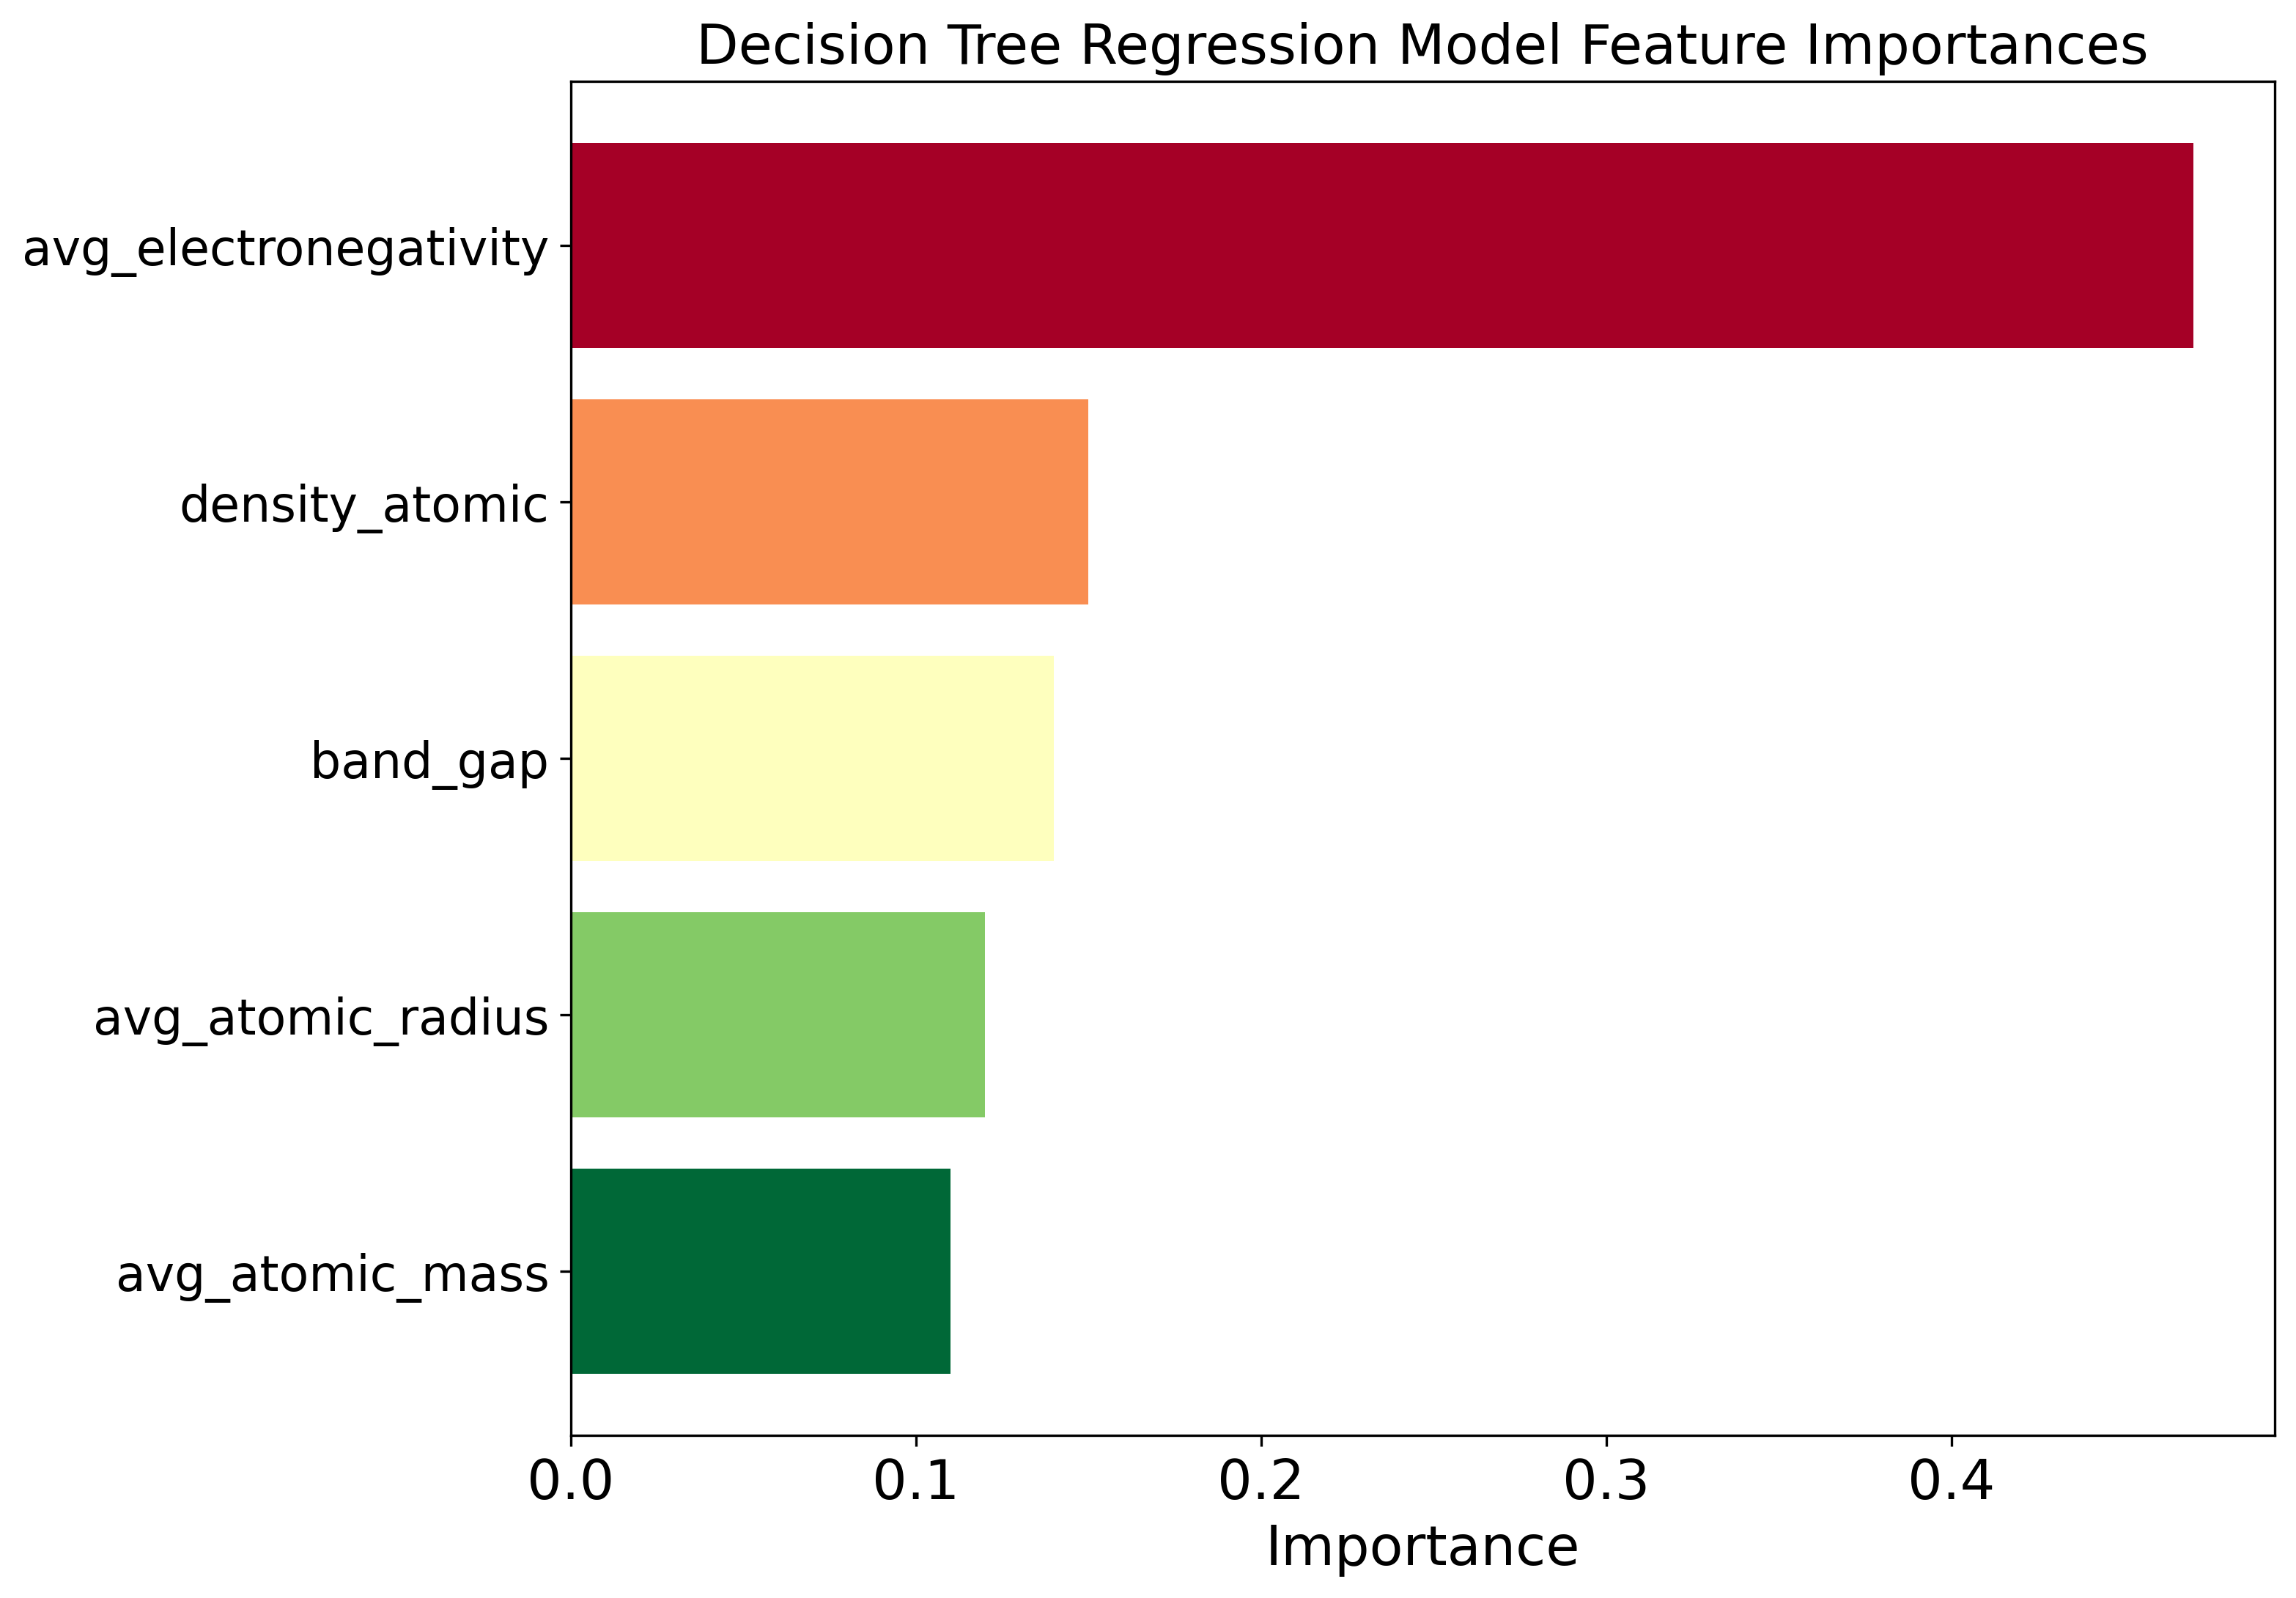


4. Random Forest Regression
The random forest regresson model performed significantly better than any of the other 3 models. Metrics before optimization were a validation R^2 score of 0.61, validation MAE of 0.282, validation MaxE of 1.925, test R^2 of 0.62, test MAE score of 0.322, and a test MaxE of 2.054. Feature importance analysis was also done on this model and produced the below plot, where you can see that the feature importances agree with the decision tree model, however, not at the same importance value:
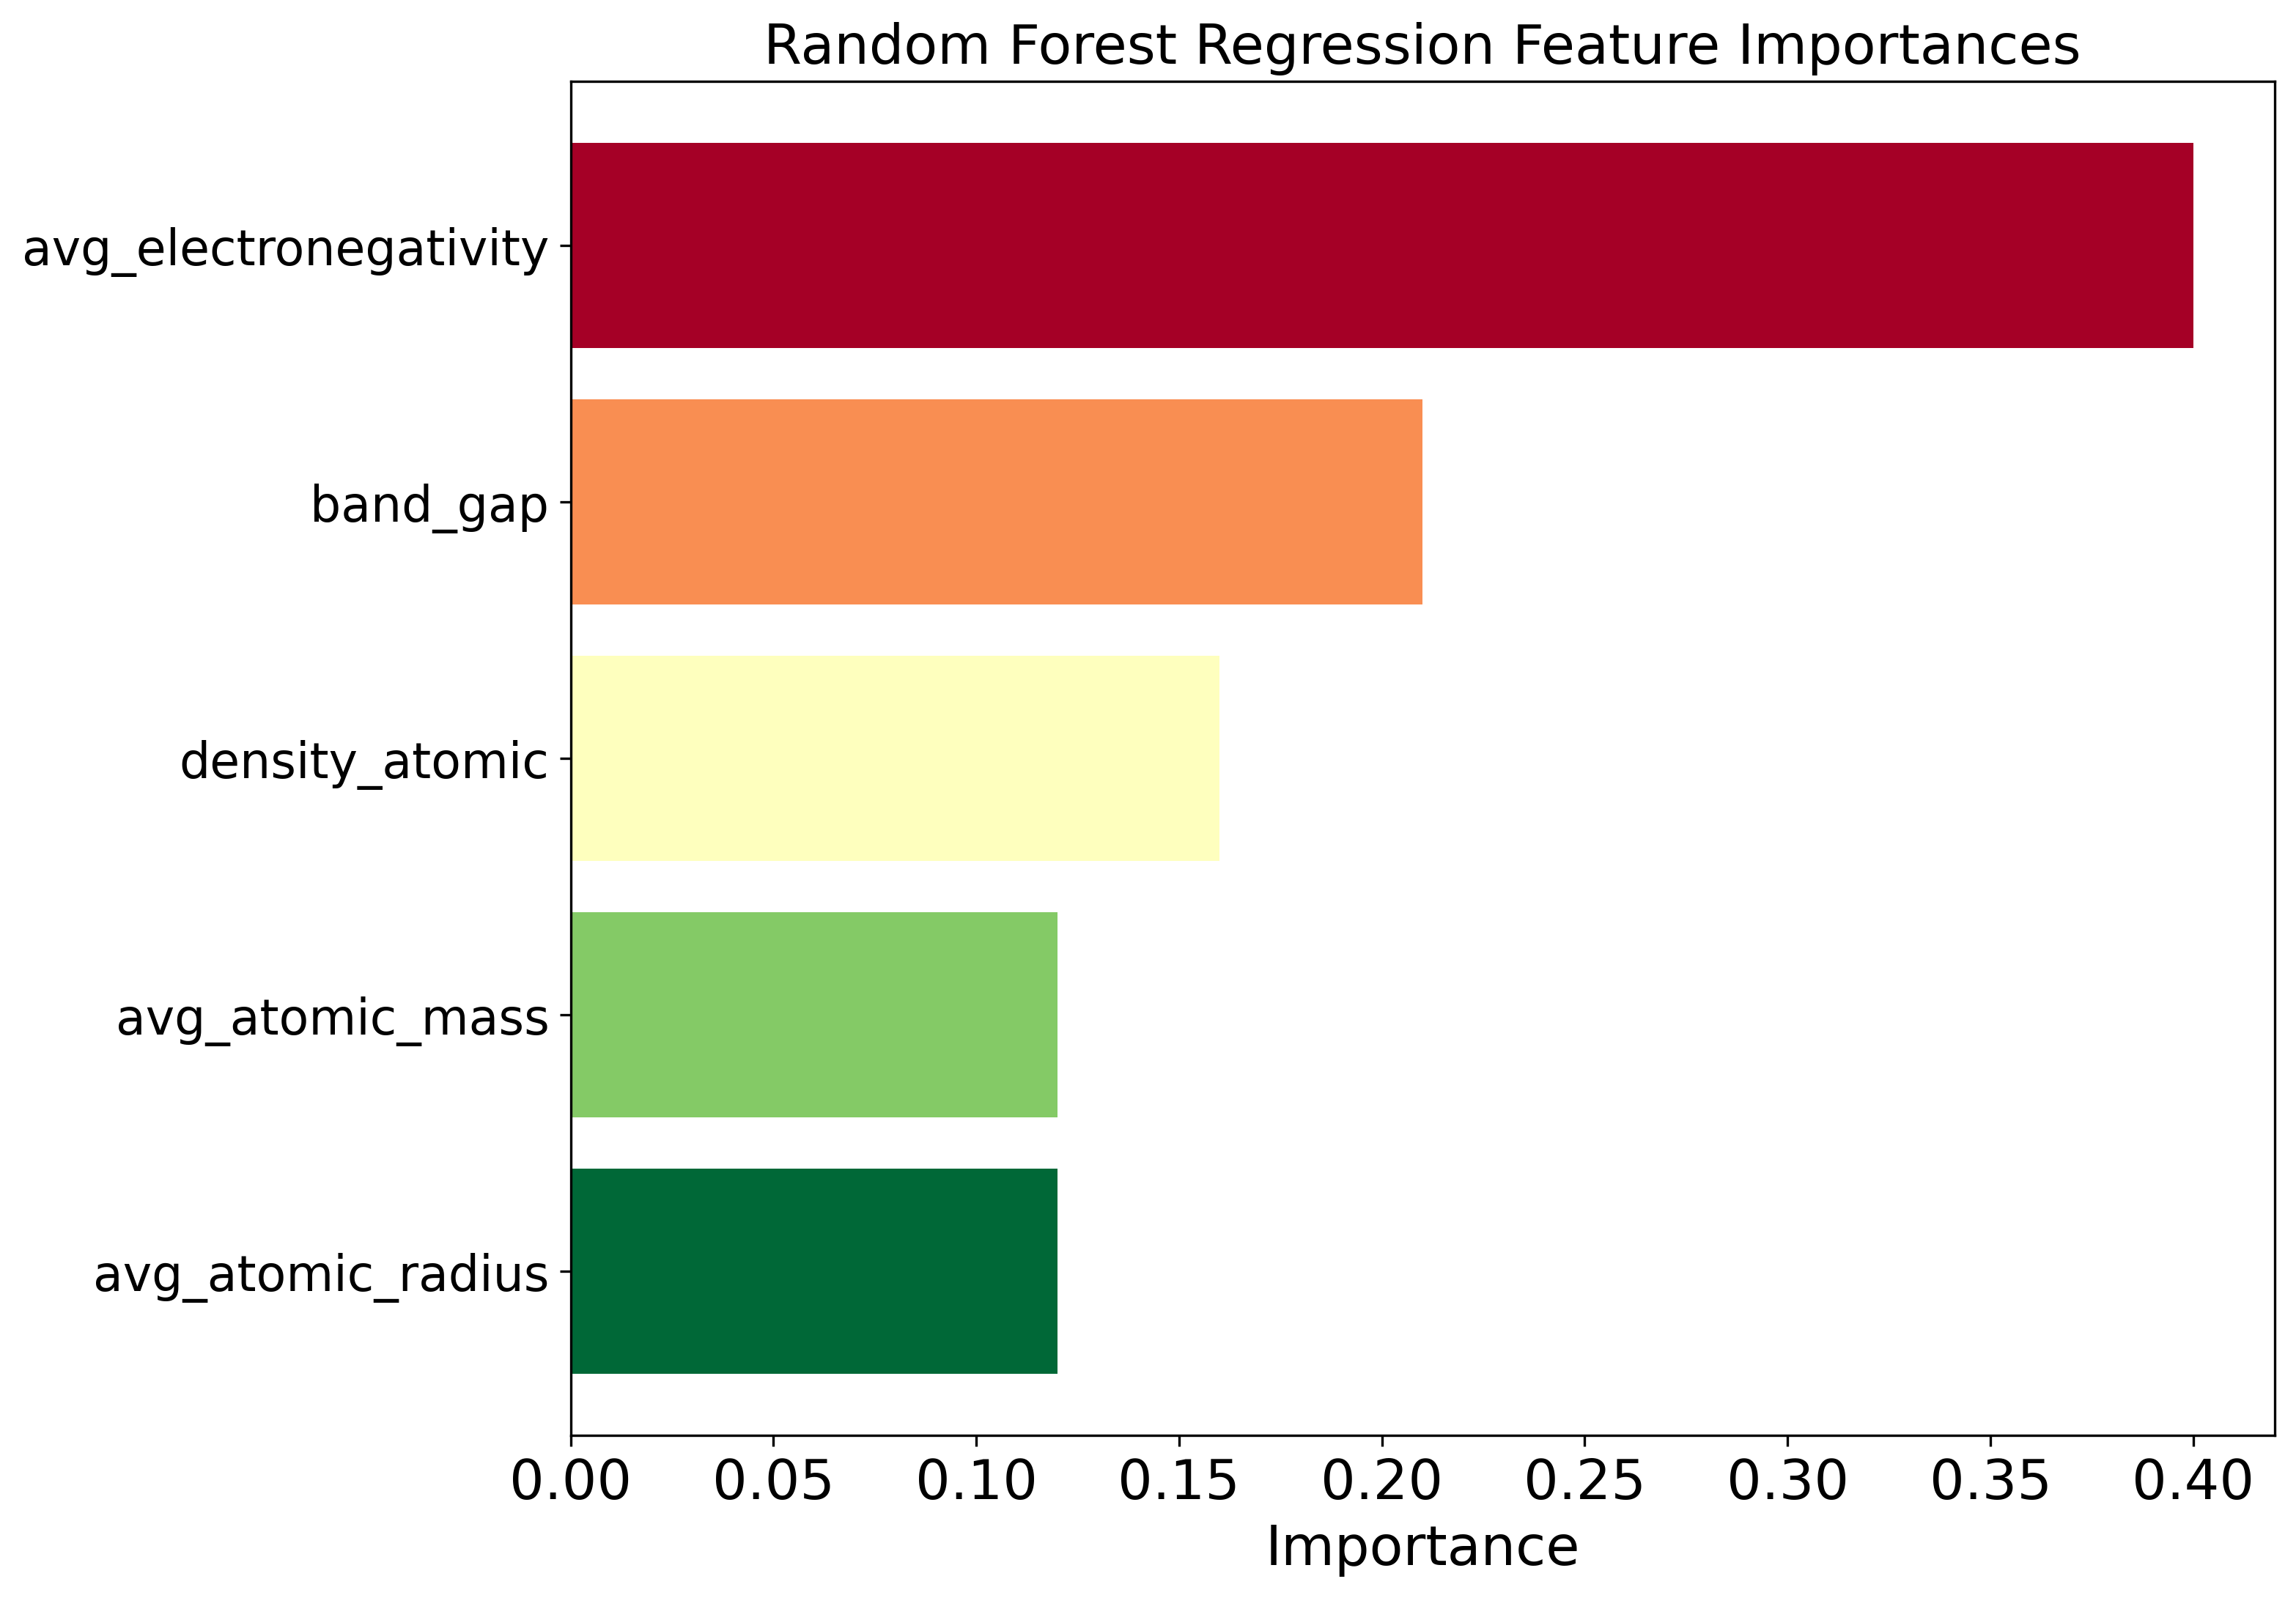

The random forest regresson model was then tuned using best model fitting and retrained for its optimal parameters. The metrics improved slightly and better clustering of test results were seen.

Discrepencies between the linear and tree/random forest feature importances were a cause for concern. Due to the higher metric values of the tree/random forest models, conclusions were made based on their results.

Features that did not affect formation energy were average atomic mass and average atomic radius. It was suprising that electronegativy did not have a heavier weight on the predicitions, because hisotrically electronegativity has a high impact on formation energy. Features that could be helpful if doing this analysis would electron affinity, ionization energy, and orbital data such as p-orbital radius and HOMO/LUMO levels. I did investigate ways to possibly include such data using other modules from pymatgen, but was unsuccessful due to limited time and knowledge.

***Data splitting***

In [ ]:
# defining X,y

X = mp_query.drop(['formula', 'material_id', 'formation_energy', 'metal_nonmetal'], axis=1).copy()
y = mp_query['formation_energy']


In [ ]:
# training data using train, test, and validation split.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=12)

# display(X_train)
# display(X_test)
# display(y_train)
# display(y_test)
# display(X_val)
# display(y_val)

***Linear Regression***

K = 2.3 + -5.56e-03 density_atomic + -2.38e-01 band_gap + -6.88e-01 avg_atomic_radius + 1.90e-03 avg_atomic_mass + -9.28e-01 avg_electronegativity


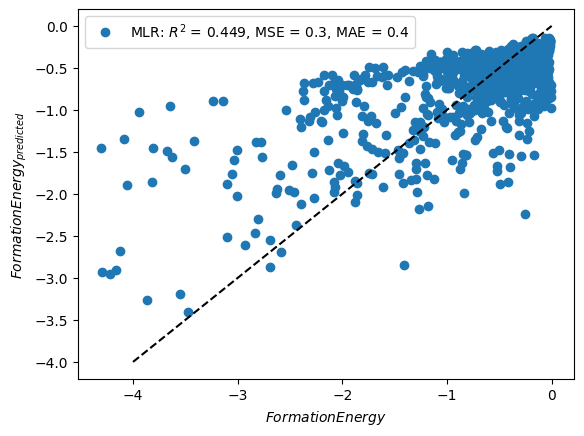

In [ ]:
reg = LinearRegression()

reg.fit(X_train, y_train)
ypred = reg.predict(X_test)


#Calculate R2 and MSE metrics using y_test
r2 = r2_score(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)


#Print regression equation
equation = ["%.2e %s" % (c, v) for c, v in zip(reg.coef_, X.columns)]
print("Formation Energy = %.1f + %s" % (reg.intercept_, " + ".join(equation)))

#Plot data
label = "MLR: $R^2$ = %.3f, MSE = %.1f, MAE = %.1f" % (r2, mse, mae)
plt.plot(y_test, ypred, "o", label=label)
plt.ylabel("$Formation Energy_{predicted}$")
plt.xlabel("$Formation Energy$")
plt.legend()
plt.plot([-4,0], [-4,0], "k--");

Formation_Energy = 2.3 + -5.56e-03 density_atomic + -2.38e-01 band_gap + -6.88e-01 avg_atomic_radius + 1.90e-03 avg_atomic_mass + -9.28e-01 avg_electronegativity


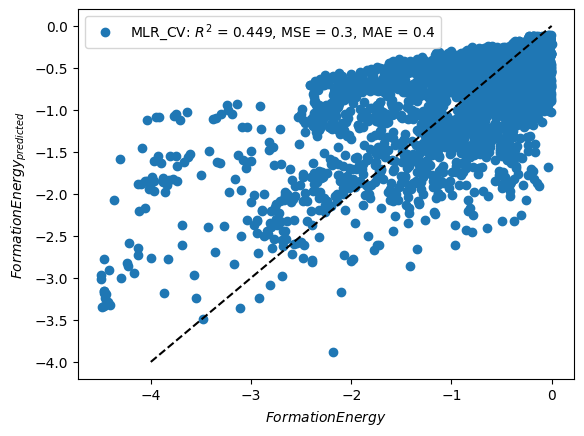

In [ ]:
# Cross Validation to theoretically improve regression metrics.

kfold = KFold(n_splits=2, shuffle=True, random_state=2)
reg_cv = LinearRegression()
ypred_cv = cross_val_predict(reg_cv, X, y, cv=kfold)

r2_cv = r2_score(y, ypred_cv)
mse_cv = mean_squared_error(y, ypred_cv)
mae_cv = mean_absolute_error(y, ypred_cv)

#Print regression equation
equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, X.columns)]
print("Formation_Energy = %.1f + %s" % (reg.intercept_, " + ".join(equation)))

#Plot data
label_cv = "MLR_CV: $R^2$ = %.3f, MSE = %.1f, MAE = %.1f" % (r2_cv, mse_cv, mae_cv)
plt.plot(y, ypred_cv, "o", label=label_cv)
plt.ylabel("$Formation Energy_{predicted}$")
plt.xlabel("$Formation Energy$")
plt.legend()
plt.plot([-4, 0], [-4, 0], "k--");


***LASSO***

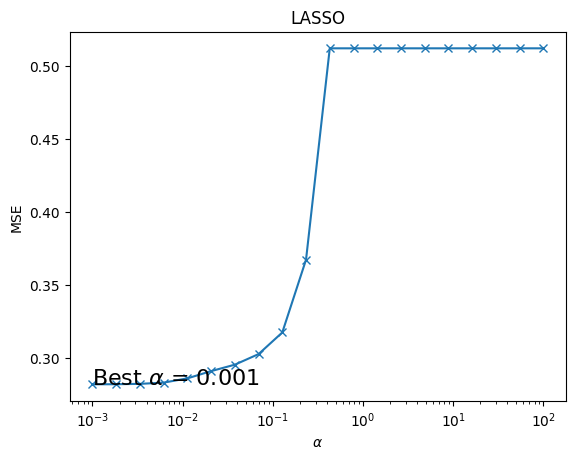

In [ ]:

scaler = StandardScaler()
scaler.fit(X)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(X)

alphas = np.logspace(-3, 2, 20)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(z, y)
    scores = cross_validate(lasso, z, y, cv=kfold, scoring="neg_mean_squared_error")
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(lasso.coef_))

features = ['density_atomic', 'band_gap', 'avg_atomic_radius', 'avg_atomic_mass', 'avg_electronegativity']
cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"] + features)
plt.plot(cv_results["alpha"], cv_results["score"], "-x")
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
plt.title("LASSO")
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(
    r"Best $\alpha$ = %.3f" % best_alpha,
    (best_alpha, cv_results["score"].min()),
    fontsize=16,
);

In [ ]:
reg = Lasso(alpha=best_alpha, max_iter=10000)
reg.fit(X, y)

real_coef = reg.coef_ / stds_
real_interp = reg.intercept_ - means_.dot(real_coef)

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features) if abs(v) > 0]
print("Formation Energy = %.1f + %s" % (real_interp, " + ".join(equation)))

Formation Energy = 9.4 + -7.87e-04 density_atomic + -2.02e-01 band_gap + -1.78e+00 avg_atomic_radius + 3.97e-05 avg_atomic_mass + -2.05e+00 avg_electronegativity


***Decision Tree***

Mean Squared Error TESTING: 0.2706158048925238
R-squared TESTING: 0.5096624261646213


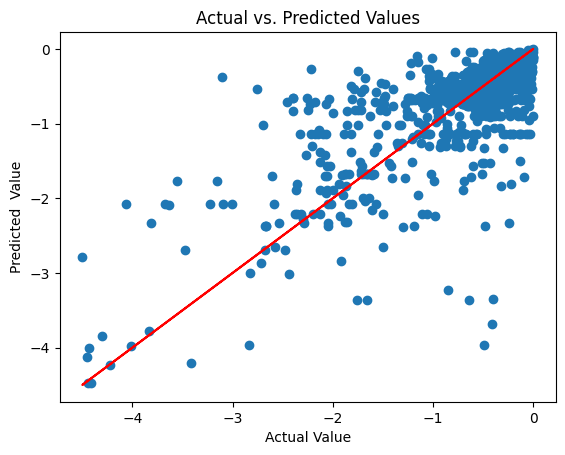

Mean Squared Error: 0.2706158048925238
R-squared: 0.5096624261646213


In [159]:
# Decision Tree

dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error TESTING:", mse)
print("R-squared TESTING:", r2)


# plot
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,color='r')
plt.xlabel("Actual Value")
plt.ylabel("Predicted  Value")
plt.title("Actual vs. Predicted Values")
plt.show()
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Variable: avg_electronegativity Importance: 0.47
Variable: density_atomic        Importance: 0.16
Variable: band_gap              Importance: 0.14
Variable: avg_atomic_radius     Importance: 0.12
Variable: avg_atomic_mass       Importance: 0.12


<ipython-input-161-386bb56036dd>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlGn')


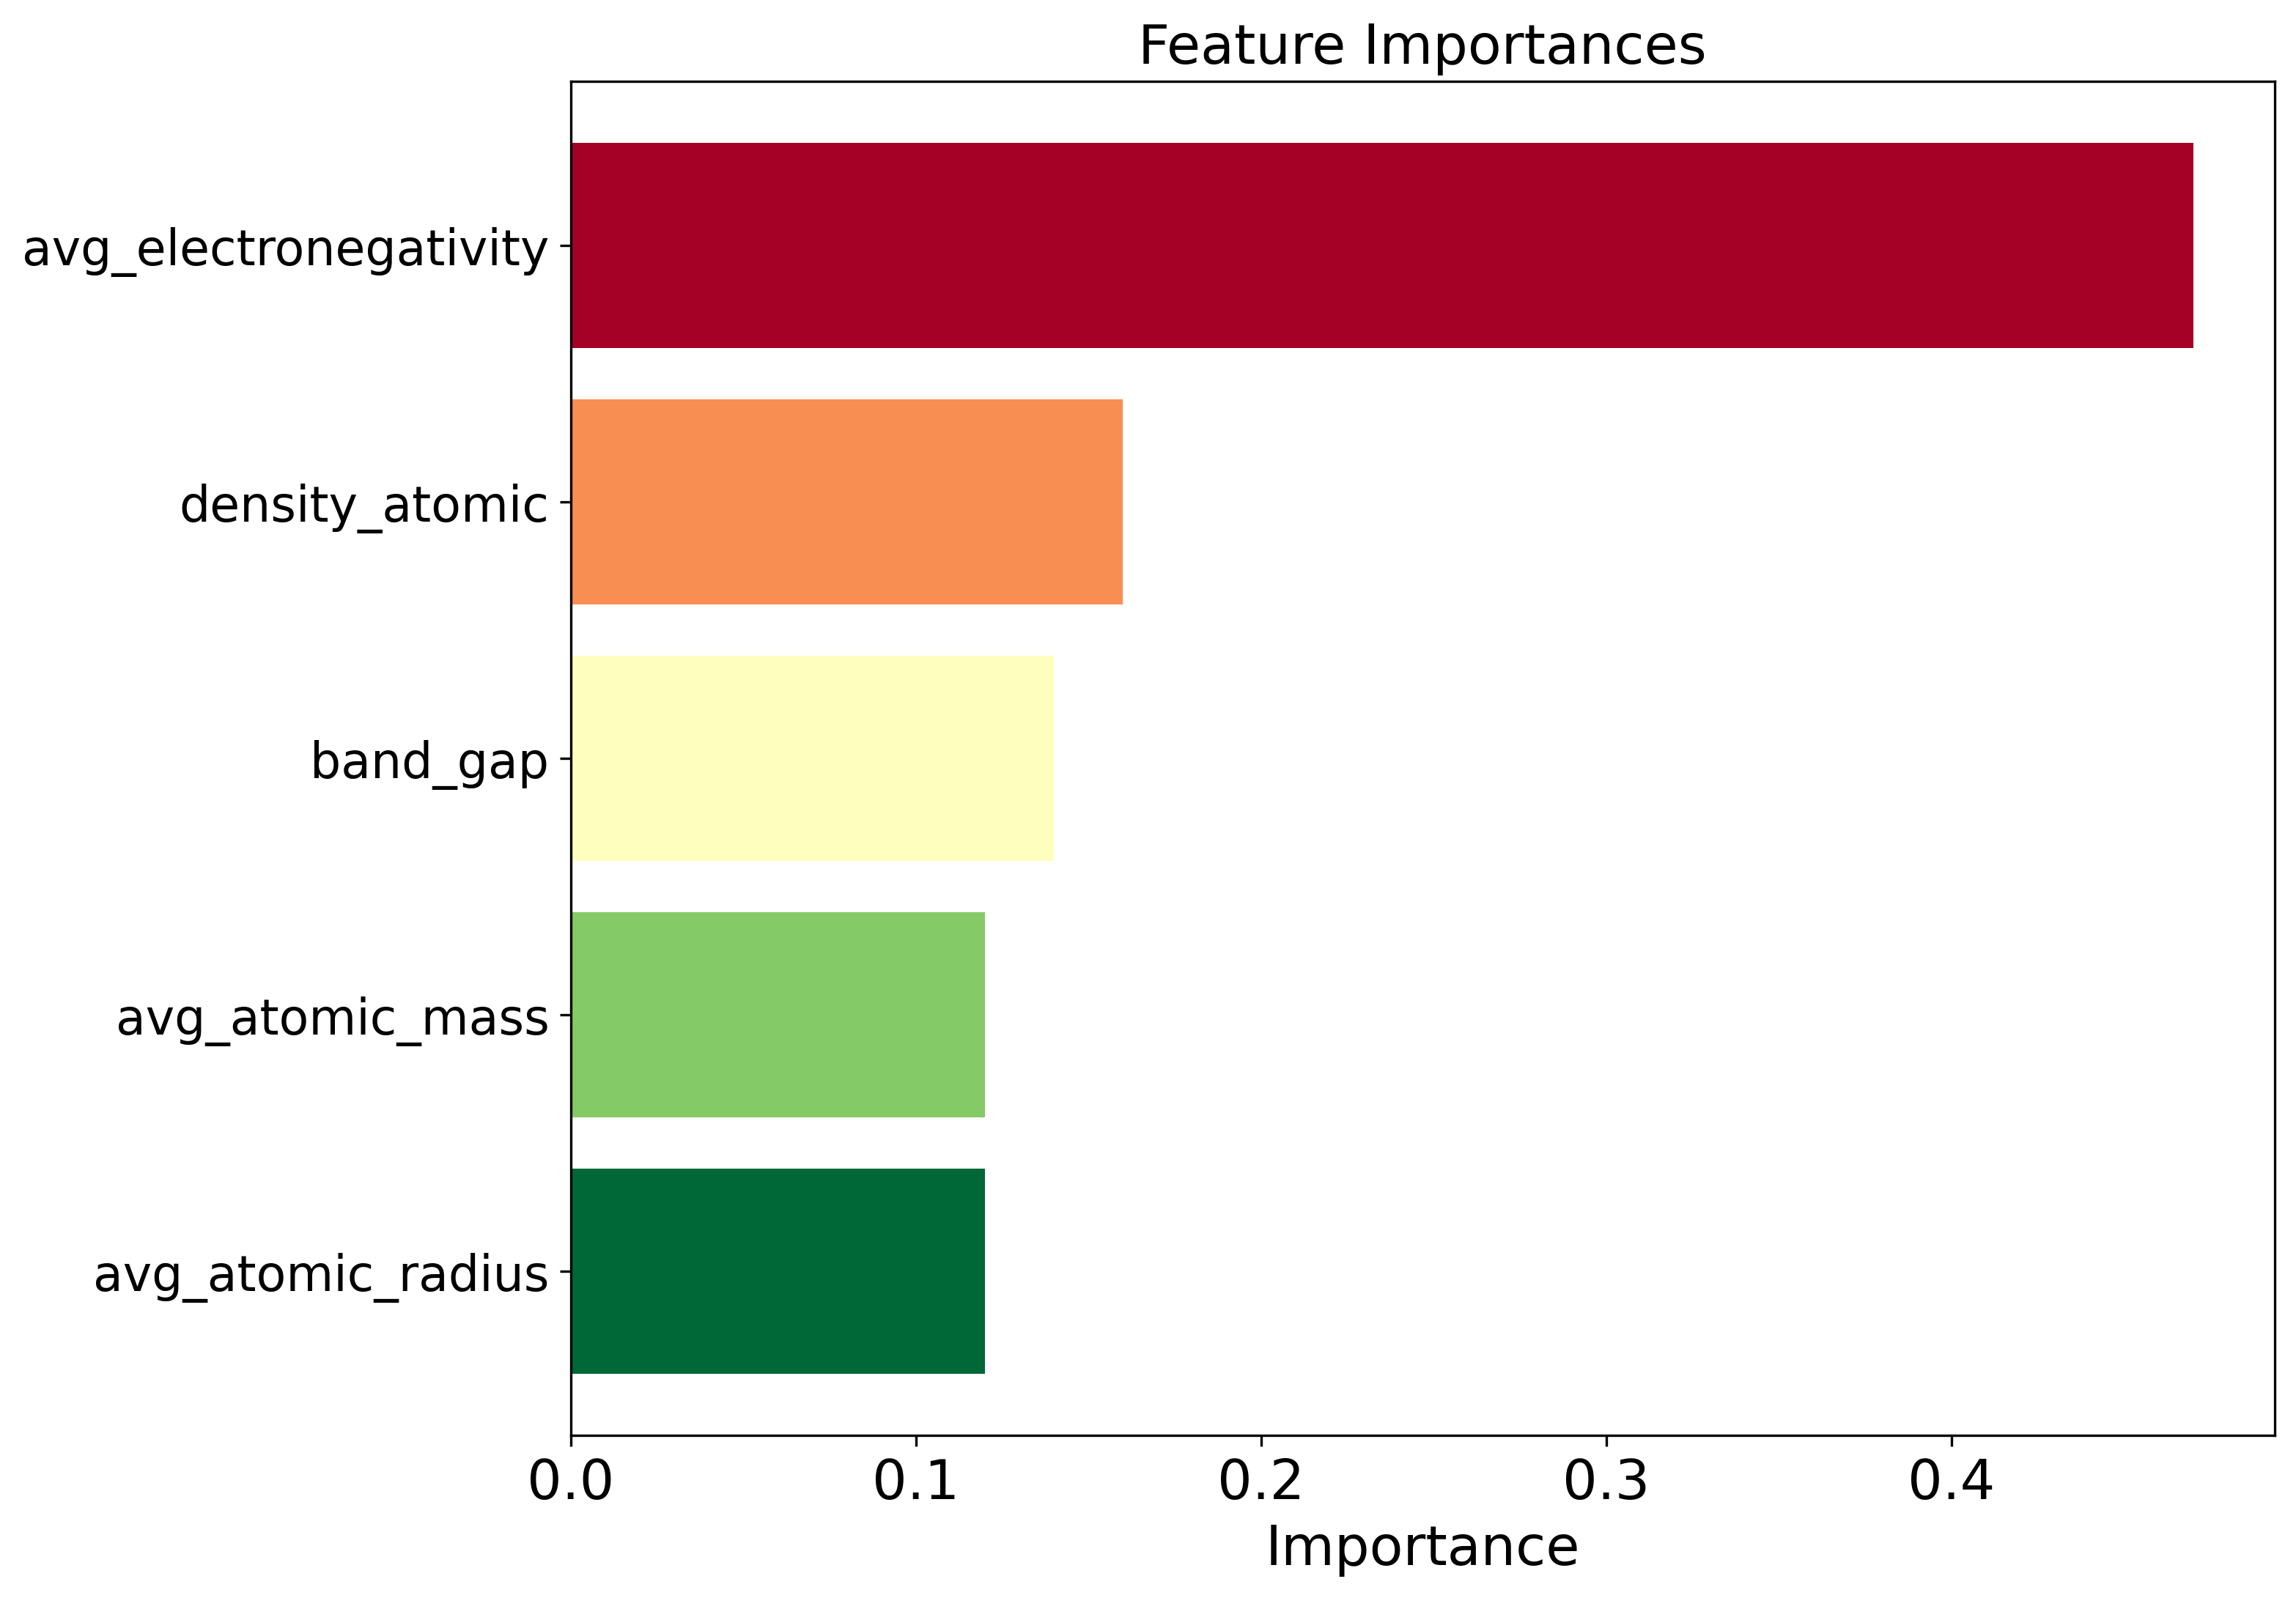

In [161]:
# feature importances analysis

feature_importances = dt.feature_importances_
feature_names = X.columns
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 8), dpi=300)

# Get numerical feature importances
importances = list(dt.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:21} Importance: {}'.format(*pair)) for pair in feature_importances];
importances = list(dt.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=False)

# Define a colormap ranging from red (most important) to green (least important)
colormap = plt.cm.get_cmap('RdYlGn')
colors = [colormap(i) for i in np.linspace(0, 1, len(feature_importances))][::-1]

# Create a horizontal bar chart with colored bars
plt.barh(range(len(feature_importances)), [val[1] for val in feature_importances], align='center', color=colors)
plt.yticks(range(len(feature_importances)), [val[0] for val in feature_importances],fontsize=16)
plt.xlabel('Importance',fontsize=18)
plt.title('Feature Importances',fontsize=18)
plt.xticks(fontsize=18)  # Add this line to adjust x-axis tick label font size
plt.show()

***Random Forest Regression***

In [ ]:
# train model

labels = np.array(y_val)
labels_test = np.array(y_test)

features = X_val
features_test = X_test

feature_list = list(features.columns)
features_pandas = features
feature_list_test = list(features_test.columns)
features_pandas_test = features_test
features = np.array(features)
features_test = np.array(features_test)
train_features, validation_features, train_labels, validation_labels = train_test_split(features, labels, test_size=0.20, random_state=42, shuffle=True)
hyperparameters = {
    'max_depth': 42,
    'min_samples_split': 3,
    'n_estimators': 1000,
    'random_state': 42
}
my_model = RandomForestRegressor(**hyperparameters)

my_model.fit(train_features, train_labels)

RandomForestRegressor(max_depth=42, min_samples_split=3, n_estimators=1000,
                      random_state=42)

In [162]:
# Making predictions on the validation set
validation_predictions = rfr.predict(validation_features)

# Computes MSE, MAE, MaxAE, and R-squared for validation set
mse_validation = mean_squared_error(validation_labels, validation_predictions)
mae_validation = mean_absolute_error(validation_labels, validation_predictions)
maxae_validation = max_error(validation_labels, validation_predictions)
r2_validation = r2_score(validation_labels, validation_predictions)

# Making predictions on the test set
test_predictions = rfr.predict(features_test)

# Computes MSE, MAE, MaxAE, and R-squared for test set
mse_test = mean_squared_error(labels_test, test_predictions)
mae_test = mean_absolute_error(labels_test, test_predictions)
maxae_test = max_error(labels_test, test_predictions)
r2_test = r2_score(labels_test, test_predictions)

# Print metrics
print("Validation Set:")
print("Mean Squared Error:", mse_validation)
print("Mean Absolute Error:", mae_validation)
print("Max Absolute Error:", maxae_validation)
print("R-squared:", r2_validation)

print("\nTest Set:")
print("Mean Squared Error:", mse_test)
print("Mean Absolute Error:", mae_test)
print("Max Absolute Error:", maxae_test)
print("R-squared:", r2_test)

Validation Set:
Mean Squared Error: 0.18242188452554692
Mean Absolute Error: 0.28227334915675895
Max Absolute Error: 1.924649905667176
R-squared: 0.6072092329448219

Test Set:
Mean Squared Error: 0.21147380322986795
Mean Absolute Error: 0.3220334524534177
Max Absolute Error: 2.0536467050480725
R-squared: 0.6168237415155554


In [ ]:
# plot figure and metrics

plt.figure(figsize=(12, 8), dpi=300)
plt.scatter(rfr.predict(train_features), train_labels, label='Train', marker='.', color='orange', s=75)
plt.scatter(rfr.predict(validation_features), validation_labels, label='Validation', marker='.', color='blue', s=75)
plt.scatter(rfr.predict(features_test), labels_test, label='Test', marker='.', color='Green', s=75)
plt.grid()
plt.legend(prop={'size': 22})
plt.ylabel('Formation Energry', fontsize=22)
plt.xlabel('Formation Energy Predicted', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(labels, labels, color='r')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.text(0.55, 0.39, 'Validation $R^2$: {:.2f}'.format(r2_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.335, 'Validation MAE: {:.3f}'.format(mae_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.28, 'Validation MaxE: {:.3f}'.format(maxae_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)

plt.text(0.55, 0.20, 'Test $R^2$: {:.2f}'.format(r2_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.145, 'Test MAE: {:.3f}'.format(mae_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.095, 'Test MaxE: {:.3f}'.format(maxae_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()


In [ ]:
# feature importance analysis

plt.figure(figsize=(10, 8), dpi=300)

# Get numerical feature importances
importances = list(my_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:21} Importance: {}'.format(*pair)) for pair in feature_importances];
importances = list(my_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=False)

# Define a colormap ranging from red (most important) to green (least important)
colormap = plt.cm.get_cmap('RdYlGn')
colors = [colormap(i) for i in np.linspace(0, 1, len(feature_importances))][::-1]

# Create a horizontal bar chart with colored bars
plt.barh(range(len(feature_importances)), [val[1] for val in feature_importances], align='center', color=colors)
plt.yticks(range(len(feature_importances)), [val[0] for val in feature_importances],fontsize=16)
plt.xlabel('Importance',fontsize=18)
plt.title('Feature Importances',fontsize=18)
plt.xticks(fontsize=18)  # Add this line to adjust x-axis tick label font size
plt.show()

plt.savefig('features_importance_tree.png')


Several iterations of the below code were used to tune hyperparameters for this regression model.

In [164]:
param_grid = {
    'max_depth': [15,17,21],
    'min_samples_split': [3, 5, 10],
    'n_estimators': [1500, 1700, 2000]
}

model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(train_features, train_labels)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(train_features, train_labels)

KeyboardInterrupt: ignored

In [ ]:
# new metrics using opitmized hyperparameters

# Make predictions on the validation set
validation_predictions = best_model.predict(validation_features)

# Compute MSE, MAE, MaxAE, and R-squared for validation set
mse_validation = mean_squared_error(validation_labels, validation_predictions)
mae_validation = mean_absolute_error(validation_labels, validation_predictions)
maxae_validation = max_error(validation_labels, validation_predictions)
r2_validation = r2_score(validation_labels, validation_predictions)

# Make predictions on the test set
test_predictions = best_model.predict(features_test)

# Compute MSE, MAE, MaxAE, and R-squared for test set
mse_test = mean_squared_error(labels_test, test_predictions)
mae_test = mean_absolute_error(labels_test, test_predictions)
maxae_test = max_error(labels_test, test_predictions)
r2_test = r2_score(labels_test, test_predictions)

# Print metrics
print("Validation Set:")
print("Mean Squared Error:", mse_validation)
print("Mean Absolute Error:", mae_validation)
print("Max Absolute Error:", maxae_validation)
print("R-squared:", r2_validation)

print("\nTest Set:")
print("Mean Squared Error:", mse_test)
print("Mean Absolute Error:", mae_test)
print("Max Absolute Error:", maxae_test)
print("R-squared:", r2_test)

Validation Set:
Mean Squared Error: 0.23420782555135508
Mean Absolute Error: 0.33297868202514636
Max Absolute Error: 2.232014684659352
R-squared: 0.5634882778956649

Test Set:
Mean Squared Error: 0.22666125089894276
Mean Absolute Error: 0.3151764843860846
Max Absolute Error: 2.684506646102303
R-squared: 0.5964178238698506


In [ ]:
plt.figure(figsize=(12, 8), dpi=300)
plt.scatter(best_model.predict(train_features), train_labels, label='Train', marker='.', color='orange', s=75)
plt.scatter(best_model.predict(validation_features), validation_labels, label='Validation', marker='.', color='blue', s=75)
plt.scatter(best_model.predict(features_test), labels_test, label='Test', marker='.', color='Green', s=75)
plt.grid()
plt.legend(prop={'size': 22})
plt.ylabel('DFT, eV', fontsize=22)
plt.xlabel('RF Prediction, eV', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(labels, labels, color='r')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.text(0.55, 0.39, 'Validation $R^2$: {:.2f}'.format(r2_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.335, 'Validation MAE: {:.3f}'.format(mae_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.28, 'Validation MaxE: {:.3f}'.format(maxae_validation), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)

plt.text(0.55, 0.20, 'Test $R^2$: {:.2f}'.format(r2_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.145, 'Test MAE: {:.3f}'.format(mae_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.55, 0.095, 'Test MaxE: {:.3f}'.format(maxae_test), fontsize=22, ha='left', va='top', transform=plt.gca().transAxes)



plt.tight_layout()

# ***Classification Model***



In [ ]:

mp_query.loc[mp_query.band_gap < 0.001, 'metallicity'] = 0
mp_query.loc[mp_query.band_gap >= 0.001, 'metallicity'] = 1
mp_query['metallicity'] = mp_query['metallicity'].astype('int')

mp_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   density_atomic         5149 non-null   float64
 1   band_gap               5149 non-null   float64
 2   formula                5149 non-null   object 
 3   material_id            5149 non-null   object 
 4   formation_energy       5149 non-null   float64
 5   metal_nonmetal         5149 non-null   object 
 6   avg_atomic_radius      5149 non-null   float64
 7   avg_atomic_mass        5149 non-null   float64
 8   avg_electronegativity  5149 non-null   float64
 9   metallicity            5149 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 402.4+ KB


In [ ]:

y = mp_query['metallicity']
X = mp_query[['density_atomic','avg_atomic_radius','avg_atomic_mass', 'avg_electronegativity']]


# Testing and training data sets
# 20% train
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=.2,random_state=0)
# 20% Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42)

# Create a model and train it
model = DecisionTreeClassifier(criterion ="entropy" ,max_depth = 7) # Try different values for max_depth!
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Accuracy score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))


0.9295902883156297
0.8844660194174757
[[2424  111]
 [ 121  639]]
[[732  61]
 [ 58 179]]


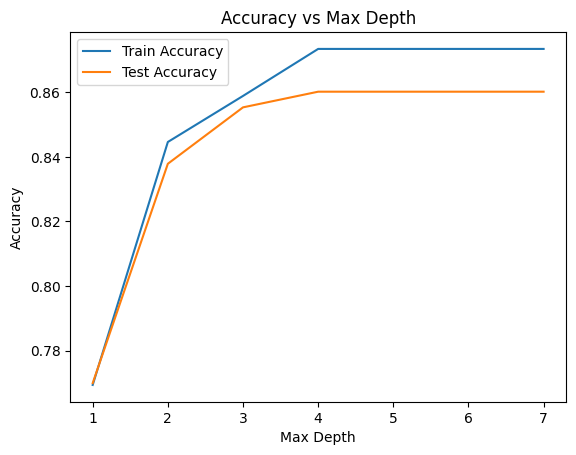

In [ ]:
# Define the range of max_depth values to test
max_depth_values = np.arange(1, 8)

# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []

# Iterate over different max_depth values
for max_depth in max_depth_values:
    # Create a model and train it
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth,max_leaf_nodes=6)
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Append accuracy scores to the lists
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

# Plot the accuracy scores
plt.plot(max_depth_values, train_accuracy, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

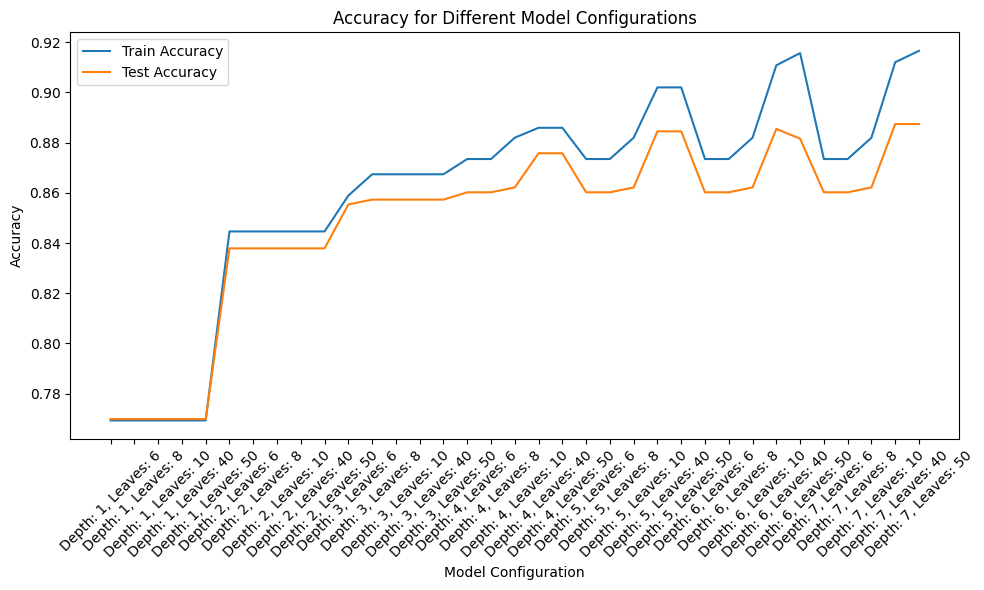

In [ ]:

# Define the range of max_depth and max_leaf_nodes values to test
max_depth_values = np.arange(1, 8)
max_leaf_nodes_values = [6, 8, 10, 40, 50]  # Modify or expand this list as needed

# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []

# Iterate over different max_depth and max_leaf_nodes values
for max_depth in max_depth_values:
    for max_leaf_nodes in max_leaf_nodes_values:
        # Create a model and train it
        model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate accuracy scores
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        # Append accuracy scores to the lists
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy')
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Model Configurations')
plt.xticks(range(len(train_accuracy)), [f'Depth: {d}, Leaves: {l}' for d in max_depth_values for l in max_leaf_nodes_values], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Random Forest

clrf = RandomForestClassifier(criterion='entropy', max_depth=7, random_state=0)
clrf.fit(X_train, y_train)

# Predict
y_train_pred = clrf.predict(X_train)
y_test_pred = clrf.predict(X_test)
# Accuracy score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))

0.9277693474962063
0.8902912621359224
[[2443   92]
 [ 146  614]]
[[751  42]
 [ 71 166]]


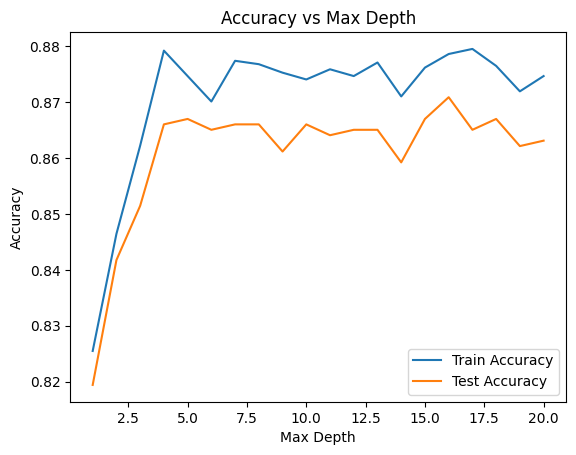

In [ ]:
# Define the range of max_depth values to test
max_depth_values = np.arange(1, 21)

# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []

# Iterate over different max_depth values
for max_depth in max_depth_values:
    # Create a model and train it
    clrf_ = RandomForestClassifier(criterion="entropy", max_depth=max_depth,max_leaf_nodes=6)
    clrf_.fit(X_train, y_train)

    # Predict
    y_train_pred = clrf_.predict(X_train)
    y_test_pred = clrf_.predict(X_test)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Append accuracy scores to the lists
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

# Plot the accuracy scores
plt.plot(max_depth_values, train_accuracy, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

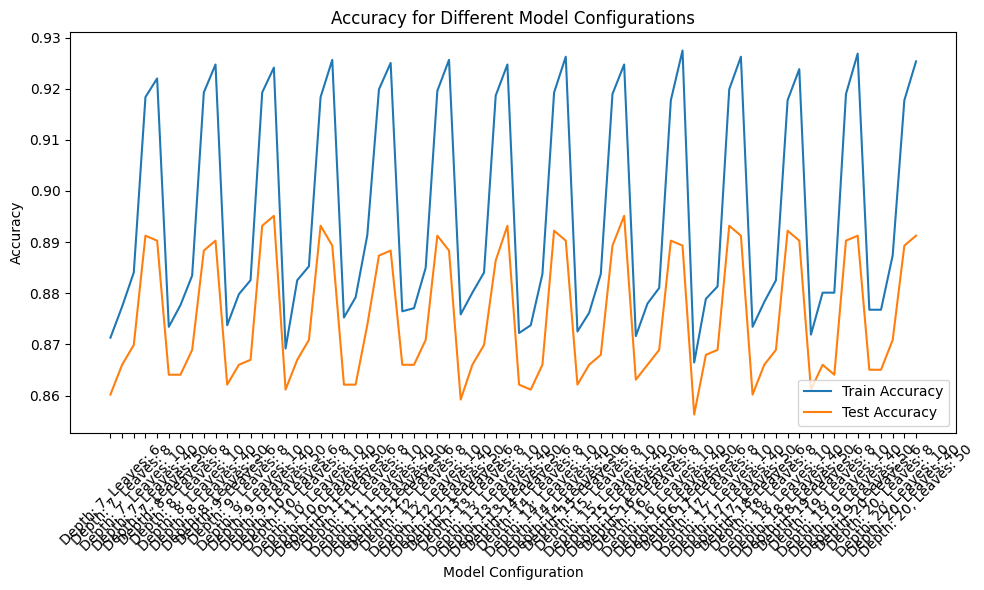

In [ ]:

# Define the range of max_depth and max_leaf_nodes values to test
max_depth_values = np.arange(7, 21)
max_leaf_nodes_values = [6, 8, 10, 40, 50]  # Modify or expand this list as needed

# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []

# Iterate over different max_depth and max_leaf_nodes values
for max_depth in max_depth_values:
    for max_leaf_nodes in max_leaf_nodes_values:
        # Create a model and train it
        clrf = RandomForestClassifier(criterion="entropy", max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
        clrf.fit(X_train, y_train)

        # Predict
        y_train_pred = clrf.predict(X_train)
        y_test_pred = clrf.predict(X_test)

        # Calculate accuracy scores
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        # Append accuracy scores to the lists
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy')
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Model Configurations')
plt.xticks(range(len(train_accuracy)), [f'Depth: {d}, Leaves: {l}' for d in max_depth_values for l in max_leaf_nodes_values], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()